In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

%matplotlibe inline

UsageError: Line magic function `%matplotlibe` not found.


In [2]:
df = pd.read_csv('data/df_train.csv')
df.head()

,Unnamed: 0,day,hashed_partner_id,hashed_campaign_id,contextid,display_env,target_env,rtbtypeid,rtbadvisibility,rtb_detectedlanguage,...,nbdisplayglobalapprox_1d_sum_xdevice,hashed_uid,hashed_xd_id,valueperclick,device_type,display_width,display_height,display_timestamp,is_display_clicked,zonecostineuro
0,0,2020-10-19,b'=\xa6\xeef\x99\xda\x1e\xb5-5\x8a\xa5\x9b\x8e...,"b""f|g\xd5T\xc8\xe2\x90\xc6\xc8\xfeL\x0c\x15\xe...",6,web,1,74.0,0.0,127.0,...,23.000000,b'\x99w[\xb8\xe1\x9e\xbaz\x01\x06\x9c\xdc\x03\...,b'\xdb\xfc\xdfBY`$\x97\xf9\xaaGn\x98\xe0{RQ\x9...,0.529218,Android,0,0,1603150590,0,0.366238
1,1,2020-10-19,b'=\xa6\xeef\x99\xda\x1e\xb5-5\x8a\xa5\x9b\x8e...,b'7\xa0%5\x98\x02\x00\xe5\xa2\xfb\xd6\xa9^\xb7...,0,web,1,74.0,0.0,127.0,...,98.252222,b'>\x1a\x00W\xb0\x81\x06\x00\x90\xc8\x8aL\xb4\...,b'\xe9\xcd\x80\xb5\x96\xcf8\x8eo(p-\x0f\xf4\xf...,0.269752,Desktop,0,0,1603150640,0,0.025551
2,2,2020-10-19,"b'\xa1l\n\xb2`\xe3\x0b""\xcd\x06\xfa\xdf\x9aj0\...","b'\xbe\xa0?\xc2</,\xa4&w\x86\xe9\x150Y\xd4\xdf...",6,web,1,4.0,2.0,10.0,...,11.000000,b'o\xa5~{\xf5\xd0C\xac_\xa9\x10\x95\x04L\x8a\x...,b'o\xa5~{\xf5\xd0C\xac_\xa9\x10\x95\x04L\x8a\x...,0.095993,Android,640,150,1603150780,0,0.289000
3,3,2020-10-19,b'=\xa6\xeef\x99\xda\x1e\xb5-5\x8a\xa5\x9b\x8e...,b'7\xa0%5\x98\x02\x00\xe5\xa2\xfb\xd6\xa9^\xb7...,6,web,1,73.0,1.0,127.0,...,57.000000,b'\xf2\x93e\xae\xadBh\x9f<<\x9e\xf0\x91q\xba\x...,"b'\x83u\xce\x10n\x9f\x10hP\x0cI\xdb \xed\xa8,E...",0.269752,iPhone,2,2,1603150840,0,0.243945
4,4,2020-10-19,b'\x0f\xbc\x909\x14[dI\xa7v]\xcc\x00\xd3\xbd\x...,b'\xa0\t^\xa5Z\x06[-\x86\x13\xd8\x08\x98\x8de\...,8,app_ios,2,74.0,0.0,127.0,...,2.000000,b'\xe6\xa9\xb2:\xc5\x04\xfd\x89/Lg\xc1\x0e\xa4...,b'\xe6\xa9\xb2:\xc5\x04\xfd\x89/Lg\xc1\x0e\xa4...,0.136416,iPhone,0,0,1603149970,0,0.647304


In [3]:
pd.DataFrame({"Valeurs manquantes":df.isnull().sum(), "Proportion manquante":df.isnull().sum()/len(df)})

,Valeurs manquantes,Proportion manquante
Unnamed: 0,0,0.000000
day,0,0.000000
hashed_partner_id,0,0.000000
hashed_campaign_id,0,0.000000
contextid,0,0.000000
display_env,0,0.000000
target_env,0,0.000000
rtbtypeid,9066,0.004887
rtbadvisibility,9066,0.004887
rtb_detectedlanguage,9066,0.004887


In [4]:
df['display_size'] = df['display_width']*df['display_height']

In [5]:
df_acp = df[['campaignctrlast24h','dayssincelastvisitdouble','nbdayssincelastclick','nbdisplay_1hour','nbdisplayglobalapprox_1d_sum_xdevice','valueperclick','display_size','zonecostineuro']]
df_acp = df_acp.dropna()

In [6]:
sc = StandardScaler()
Z = sc.fit_transform(df_acp)
Z

array([[-0.99904655, -0.39913414, -0.3080928 , ...,  1.49787279,
        -0.8866836 , -0.24451215],
       [-0.44379168, -0.43933452, -0.42467332, ...,  0.08826503,
        -0.8866836 , -0.36359572],
       [ 1.8483982 , -0.32917855, -0.28477669, ..., -0.85572066,
         0.12491194, -0.27150991],
       ...,
       [-1.0385267 , -0.35926138, -0.3314089 , ...,  1.33967981,
         0.73186926,  1.65130981],
       [ 2.24191249, -0.40776778,  0.78776414, ..., -0.58506743,
        -0.09637459, -0.36553618],
       [-0.59141726, -0.1597434 , -0.42467332, ...,  0.11573304,
         1.01005803, -0.18226094]])

In [7]:
acp = PCA(svd_solver='full')

In [8]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

8


In [9]:
print(acp.explained_variance_ratio_)

[0.20878171 0.16108921 0.15493336 0.13662952 0.1119917  0.09590611
 0.08645423 0.04421416]


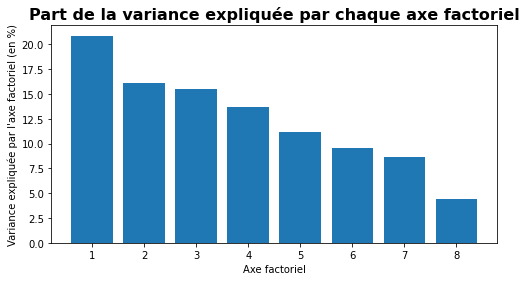

In [10]:
plt.figure(figsize=(8,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Part de la variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

In [11]:
coord_1_not_cliqued = []
coord_1_cliqued = []

coord_2_not_cliqued = []
coord_2_cliqued = []

coord_3_not_cliqued = []
coord_3_cliqued = []

for i in range(len(coord[:,0])):
    if df['is_display_clicked'][i] == 0:
        coord_1_not_cliqued.append(coord[i,0])
        coord_2_not_cliqued.append(coord[i,1])
        coord_3_not_cliqued.append(coord[i,2])
    else:
        coord_1_cliqued.append(coord[i,0])
        coord_2_cliqued.append(coord[i,1])
        coord_3_cliqued.append(coord[i,2])

In [12]:
plt.plot(coord_1_not_cliqued, coord_2_not_cliqued, '.', color='r', linestyle="None", markersize=0.2)
plt.plot(coord_1_cliqued, coord_2_cliqued, '.', color='g', linestyle="None", markersize=0.2)
plt.xlabel('Axe 1')
plt.ylabel('Axe 2')
plt.title('Premier plan factoriel')
plt.legend(['Pas cliqué', 'Cliqué'])
plt.savefig('plan_axe1_axe2.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
plt.close()

In [13]:
plt.plot(coord_1_not_cliqued, coord_3_not_cliqued, '.', color='r', linestyle="None", markersize=0.2)
plt.plot(coord_1_cliqued, coord_3_cliqued, '.', color='g', linestyle="None", markersize=0.2)
plt.xlabel('Axe 1')
plt.ylabel('Axe 3')
plt.title('Plan (Axe 1, Axe 3)')
plt.legend(['Pas cliqué', 'Cliqué'])
plt.savefig('plan_axe1_axe3.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
plt.close()

In [14]:
plt.plot(coord_2_not_cliqued, coord_3_not_cliqued, '.', color='r', linestyle="None", markersize=0.2)
plt.plot(coord_2_cliqued, coord_3_cliqued, '.', color='g', linestyle="None", markersize=0.2)
plt.xlabel('Axe 2')
plt.ylabel('Axe 3')
plt.title('Plan (Axe 2, Axe 3)')
plt.legend(['Pas cliqué', 'Cliqué'])
plt.savefig('plan_axe2_axe3.png', dpi = 500, bbox_inches='tight', figsize=(10,6))
plt.close()

In [15]:
n = len(df_acp)
p = len(df_acp.columns)

eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

print(pd.DataFrame({'Variable':df_acp.columns,'Cor_axe_1':corvar[:,0],'Cor_axe_2':corvar[:,1]}))

                               Variable  Cor_axe_1  Cor_axe_2
0                    campaignctrlast24h  -0.779373   0.348772
1              dayssincelastvisitdouble  -0.169512  -0.348016
2                  nbdayssincelastclick  -0.100087  -0.227639
3                       nbdisplay_1hour   0.361765   0.672819
4  nbdisplayglobalapprox_1d_sum_xdevice   0.265501   0.680351
5                         valueperclick   0.865882  -0.225181
6                          display_size   0.121300   0.009960
7                        zonecostineuro   0.241350  -0.166636


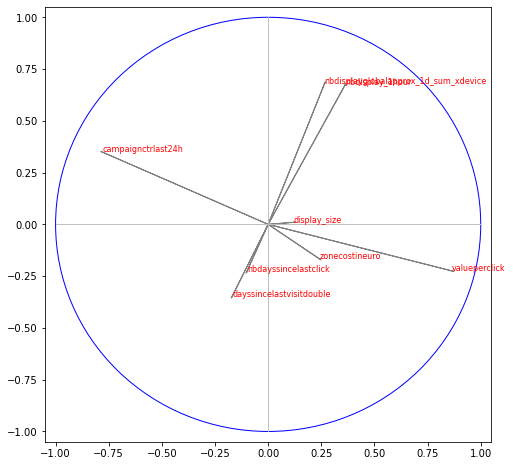

In [16]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1.05,1.05)
axes.set_ylim(-1.05,1.05)

for j in range(p):
    axes.arrow(0, 0, corvar[j,0], corvar[j,1], head_width=0.005, head_length=0.01, fc='grey', ec='grey')
    plt.annotate(df_acp.columns[j], (corvar[j,0],corvar[j,1]), size=8, color='r')

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

cercle = plt.Circle((0,0), 1, color='blue', fill=False)
axes.add_artist(cercle)

plt.show()